In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt

import shap
warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from matplotlib import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
from bayes_opt import BayesianOptimization

#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8

print(tf.__version__)


2.4.1


In [ ]:
people_vaccinated = pd.read_csv('datasets/people_vaccinated.csv',parse_dates= ['date'],encoding='utf-8-sig')
people_vaccinated.set_index('date',inplace=True)
people_vaccinated.sort_index(inplace=True)
people_vaccinated = people_vaccinated.drop(['iso_code','location','people_fully_vaccinated'], axis=1)
people_vaccinated.head()

,daily_new_fully_vaccinated
date,
2021-01-14,1342086
2021-01-15,268438
2021-01-19,412600
2021-01-20,138295
2021-01-21,233542


In [ ]:
people_vaccinated=people_vaccinated.sort_values('date')

#print the sorted values
print(people_vaccinated.head(1))

#check any missing values
people_vaccinated.isnull().sum()

            daily_new_fully_vaccinated
date                                  
2021-01-14                     1342086


daily_new_fully_vaccinated    0
dtype: int64

# Methods for time series forecasting

There are many methods that we can use for time series forecasting and there is not a clear winner. Model selection should always depend on how you data look and what are you trying to achieve. Some models may be more robust against outliers but perform worse than the more sensible and could still be the best choice depending on the use case.

When looking at your data the main split is wether we have extra regressors (features) to our time series or just the series. Based on this we can start exploring different methods for forecasting and their performance in different metrics.

In this section we will show models for both cases, time series with and without extra regressors.

**Prepare data before modeling**

In [ ]:
#We split our dataset to be able to evaluate our models

MAE={}
RMSE={}
R2_Metric={}
predictionsDict={}

split_date ='2021-03-15'
df_training = people_vaccinated.loc[people_vaccinated.index <= split_date]
df_test = people_vaccinated.loc[people_vaccinated.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('datasets/training.csv')
df_test.to_csv('datasets/test.csv')

57 days of training data 
 33 days of testing data 


It is also very important to include some naive forecast as the series mean or previous value to make sure our models perform better than the simplest of the simplest. We dont want to introduce any complexity if it does not provides any performance gain.

## Univariate-time-series-forecasting

### Simple Exponential Smoothing (SES)

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.daily_new_fully_vaccinated))):
    temp_train = people_vaccinated[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train.daily_new_fully_vaccinated)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
MAE['SES'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat.values)
RMSE['SES'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat.values)
R2_Metric['SES'] = r2_score(df_test.daily_new_fully_vaccinated, yhat.values)
predictionsDict['SES'] = yhat.values

100%|██████████| 33/33 [00:00<00:00, 253.79it/s]


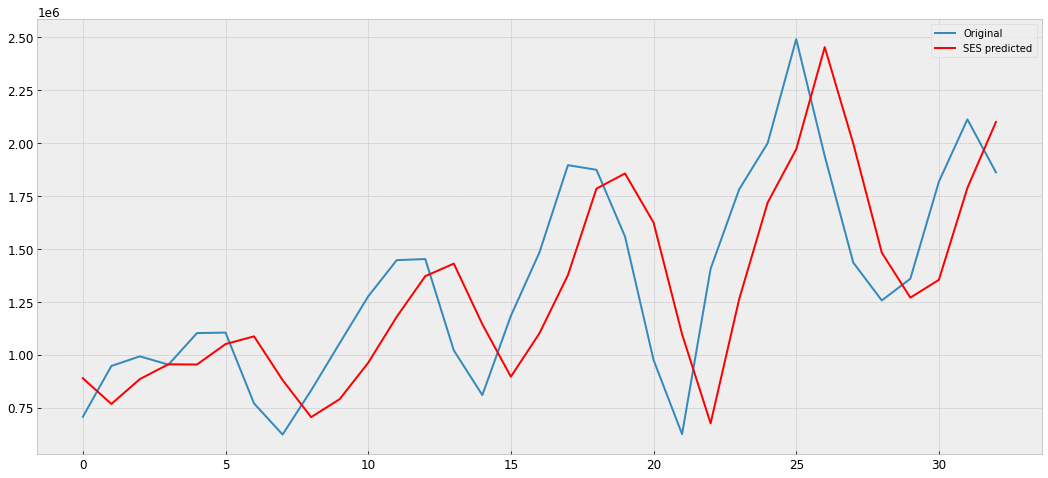

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values, label='Original')
plt.plot(yhat.values,color='red',label='SES predicted')
plt.legend()

### Holt Winter’s Exponential Smoothing (HWES)

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.daily_new_fully_vaccinated))):
    temp_train = people_vaccinated[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train.daily_new_fully_vaccinated)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
MAE['HWES'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat.values)
RMSE['HWES'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat.values)
R2_Metric['HWES'] = r2_score(df_test.daily_new_fully_vaccinated, yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 33/33 [00:00<00:00, 256.32it/s]


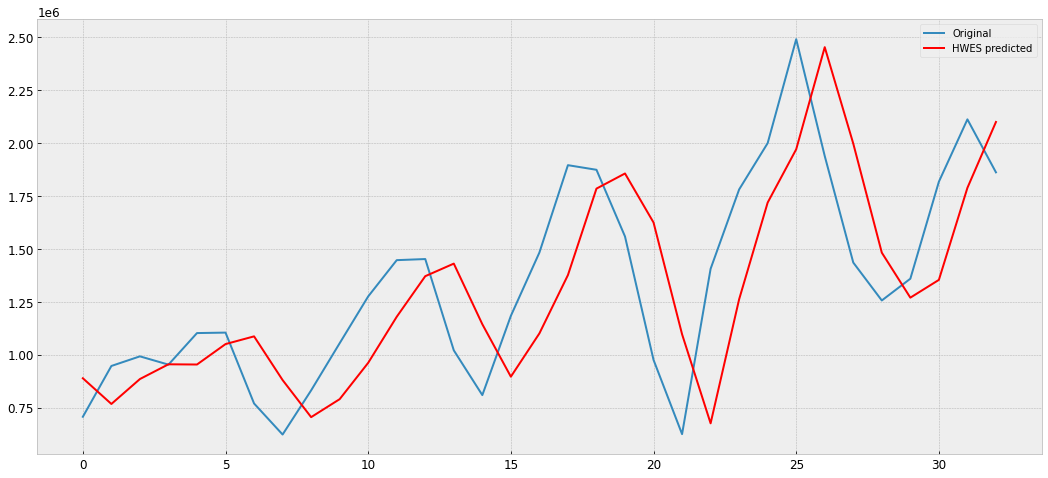

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values, label='Original')
plt.plot(yhat.values,color='red',label='HWES predicted')
plt.legend()

### Autoregression (AR)

In [ ]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.daily_new_fully_vaccinated))):
    temp_train = people_vaccinated[:len(df_training)+t]
    model = AR(temp_train.daily_new_fully_vaccinated)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
MAE['AR'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat.values)
RMSE['AR'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat.values)
R2_Metric['AR'] = r2_score(df_test.daily_new_fully_vaccinated, yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 33/33 [00:00<00:00, 702.19it/s]


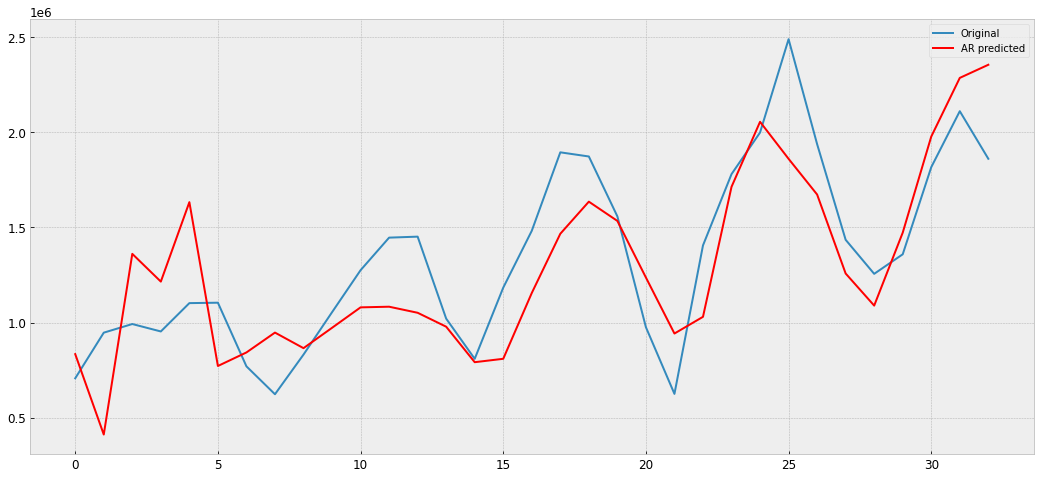

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values, label='Original')
plt.plot(yhat.values,color='red',label='AR predicted')
plt.legend()

### Moving Average (MA)

In [ ]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.daily_new_fully_vaccinated))):
    temp_train = people_vaccinated[:len(df_training)+t]
    model = ARMA(temp_train.daily_new_fully_vaccinated, order=(0, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
MAE['MA'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat.values)
RMSE['MA'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat.values)
R2_Metric['MA'] = r2_score(df_test.daily_new_fully_vaccinated, yhat.values)
predictionsDict['MA'] = yhat.values

100%|██████████| 33/33 [00:00<00:00, 86.11it/s]


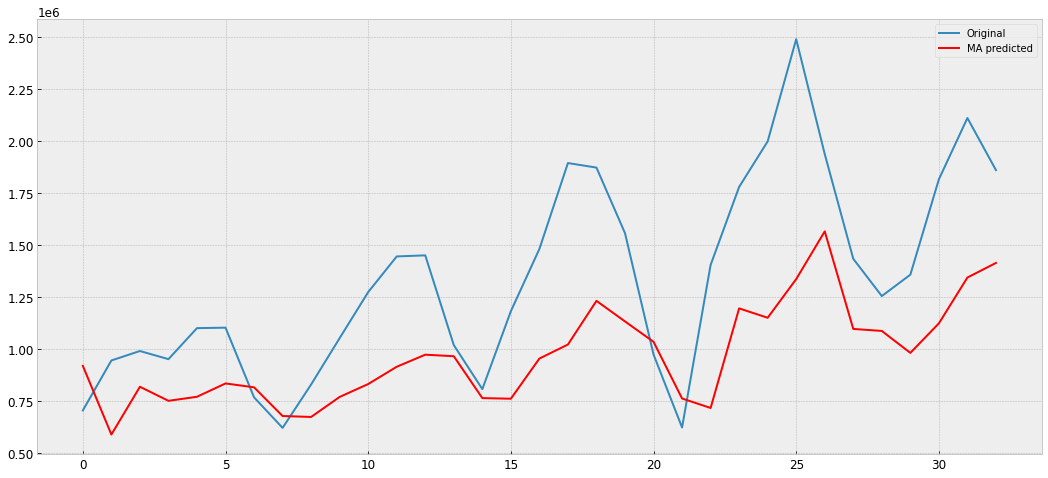

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat.values,color='red',label='MA predicted')
plt.legend()

### Autoregressive Moving Average (ARMA)

In [ ]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.daily_new_fully_vaccinated))):
    temp_train = people_vaccinated[:len(df_training)+t]
    model = ARMA(temp_train.daily_new_fully_vaccinated, order=(1, 1))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
MAE['ARMA'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat.values)
RMSE['ARMA'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat.values)
R2_Metric['ARMA'] = r2_score(df_test.daily_new_fully_vaccinated, yhat.values)
predictionsDict['ARMA'] = yhat.values

100%|██████████| 33/33 [00:00<00:00, 34.11it/s]


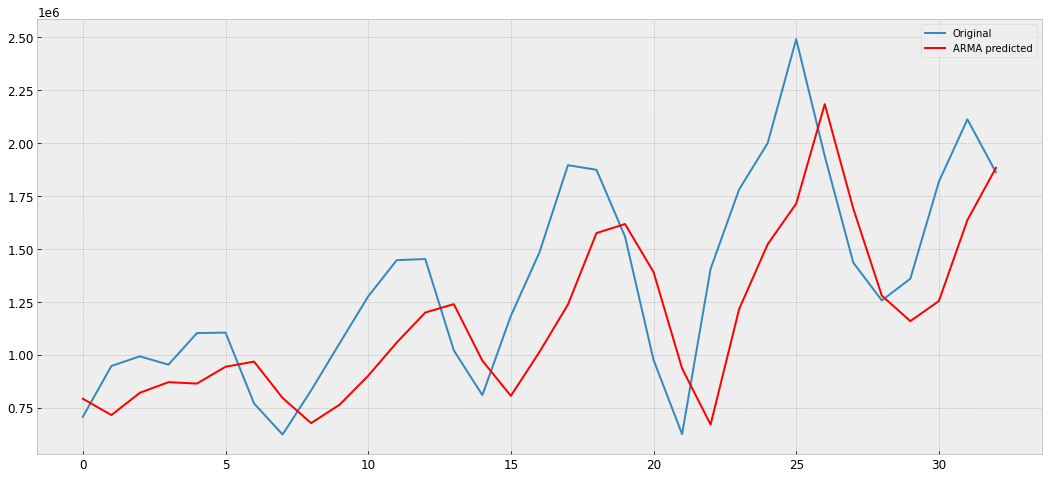

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat.values,color='red',label='ARMA predicted')
plt.legend()

### Autoregressive integrated moving average (ARIMA) 

In [ ]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.daily_new_fully_vaccinated))):
    temp_train = people_vaccinated[:len(df_training)+t]
    model = ARIMA(temp_train.daily_new_fully_vaccinated, order=(1,0, 0))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
MAE['ARIMA'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat.values)
RMSE['ARIMA'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat.values)
R2_Metric['ARIMA'] = r2_score(df_test.daily_new_fully_vaccinated, yhat.values)
predictionsDict['ARIMA'] = yhat.values

100%|██████████| 33/33 [00:00<00:00, 86.88it/s]


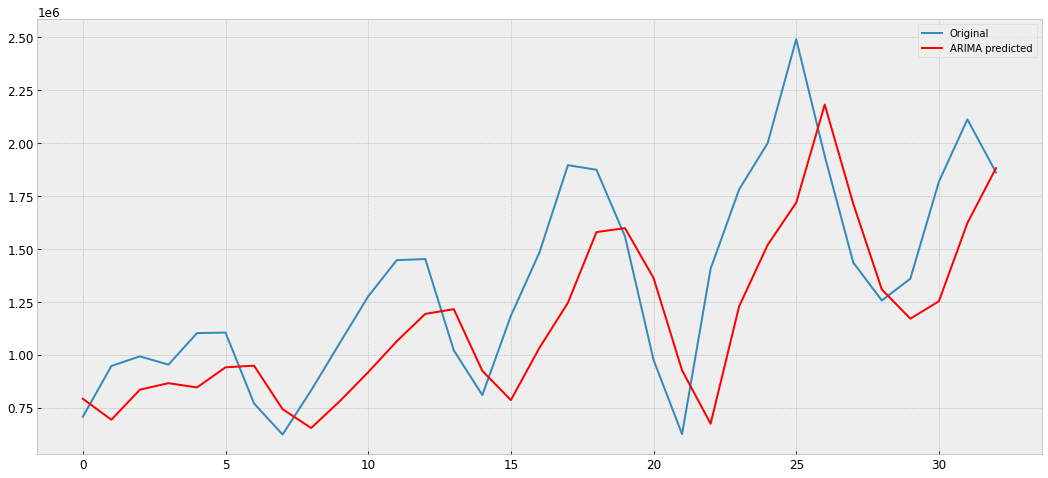

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat.values,color='red',label='ARIMA predicted')
plt.legend()

### Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [ ]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test.daily_new_fully_vaccinated))):
    temp_train = people_vaccinated[:len(df_training)+t]
    model = SARIMAX(temp_train.daily_new_fully_vaccinated, order=(1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]
    
yhat = pd.concat(yhat)
MAE['SARIMAX'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat.values)
RMSE['SARIMAX'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat.values)
R2_Metric['SARIMAX'] = r2_score(df_test.daily_new_fully_vaccinated, yhat.values)
predictionsDict['SARIMAX'] = yhat.values

100%|██████████| 33/33 [00:00<00:00, 77.10it/s]


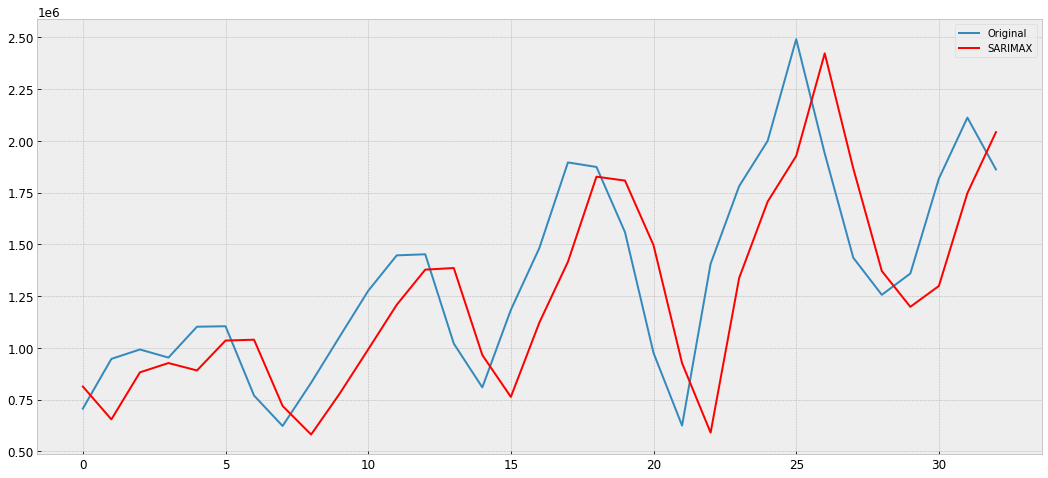

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat.values,color='red',label='SARIMAX')
plt.legend()

## Multivariate time series forecasting

In [ ]:
## ADD time features to our model
def create_time_features(df,target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'],axis=1)
    if target:
        y = df[target]
        X = X.drop([target],axis=1)
        return X, y
    
    return X

In [ ]:
X_train_df, y_train = create_time_features(df_training, target='daily_new_fully_vaccinated')
X_test_df, y_test = create_time_features(df_test, target='daily_new_fully_vaccinated')
scaler = StandardScaler() 
scaler.fit(X_train_df) #No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)  
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train,columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test,columns=X_test_df.columns)

### Linear models

#### Bayesian regression

In [ ]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
MAE['BayesianRidge'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat)
RMSE['BayesianRidge'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat)
R2_Metric['BayesianRidge'] = r2_score(df_test.daily_new_fully_vaccinated, yhat)
predictionsDict['BayesianRidge'] = yhat

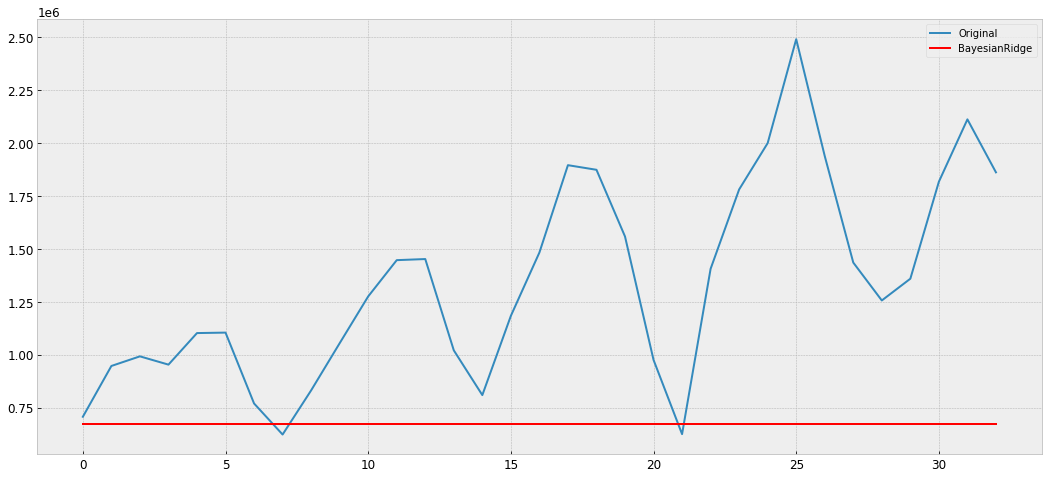

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat,color='red',label='BayesianRidge')
plt.legend()

#### Lasso

In [ ]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
MAE['Lasso'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat)
RMSE['Lasso'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat)
R2_Metric['Lasso'] = r2_score(df_test.daily_new_fully_vaccinated, yhat)
predictionsDict['Lasso'] = yhat

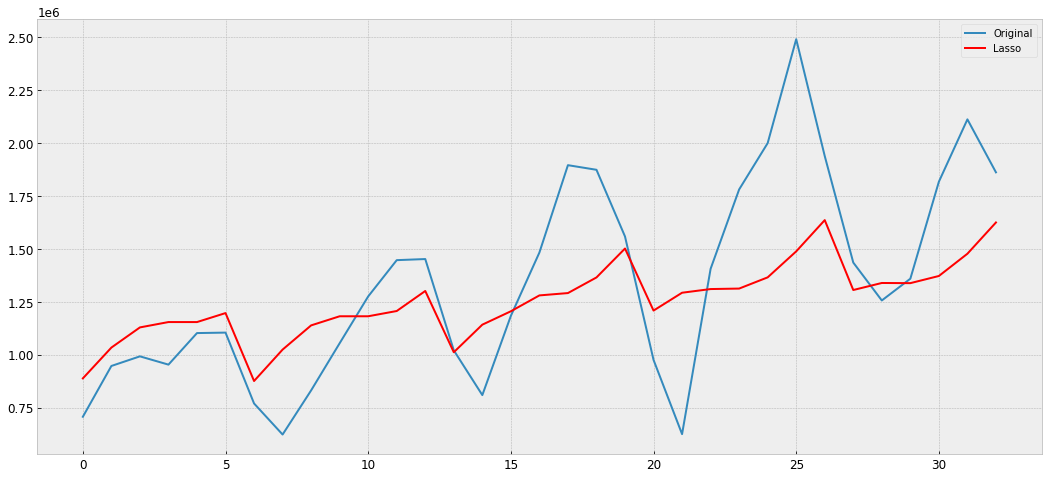

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat,color='red',label='Lasso')
plt.legend()

### Tree models

#### Randomforest

In [ ]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
MAE['Randomforest'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat)
RMSE['Randomforest'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat)
R2_Metric['Randomforest'] = r2_score(df_test.daily_new_fully_vaccinated, yhat)
predictionsDict['Randomforest'] = yhat

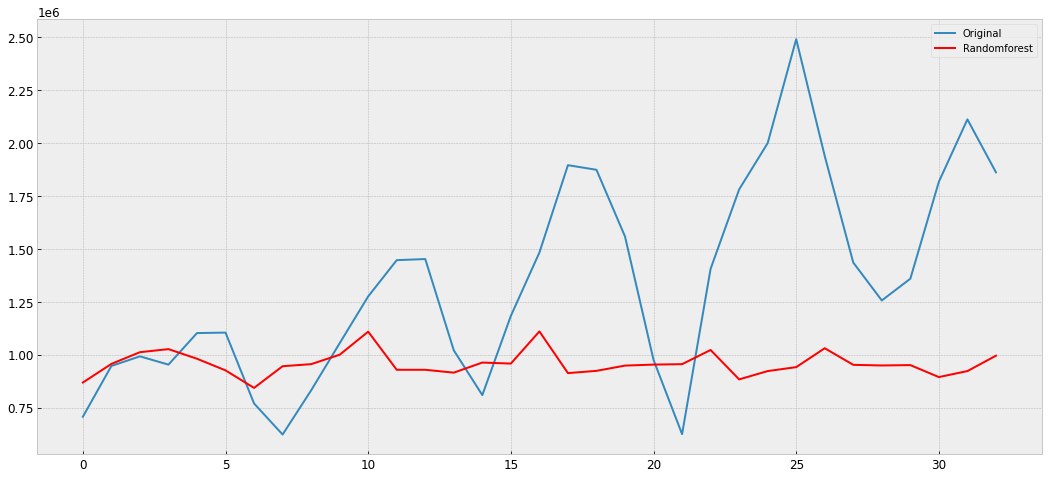

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat,color='red',label='Randomforest')
plt.legend()

#### XGBoost

In [ ]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
       verbose=False) # Change verbose to True if you want to see it train
yhat = reg.predict(X_test)
MAE['XGBoost'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat)
RMSE['XGBoost'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat)
R2_Metric['XGBoost'] = r2_score(df_test.daily_new_fully_vaccinated, yhat)
predictionsDict['XGBoost'] = yhat

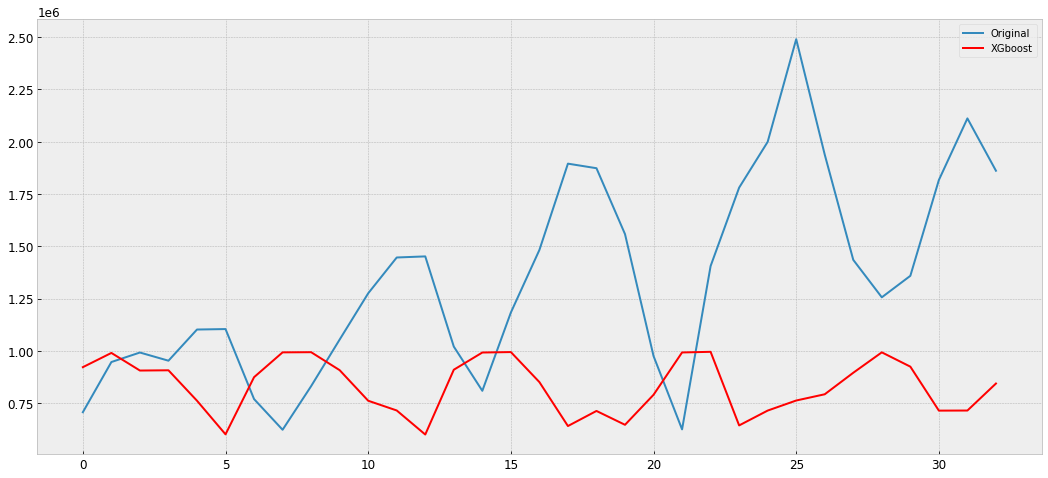

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat,color='red',label='XGboost')
plt.legend()

#### Lightgbm

A tree gradient boosting model by [microsoft](https://github.com/microsoft/LightGBM) 

In [ ]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train,y_train)
yhat = lightGBM.predict(X_test)
MAE['Lightgbm'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat)
RMSE['Lightgbm'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat)
R2_Metric['Lightgbm'] = r2_score(df_test.daily_new_fully_vaccinated, yhat)
predictionsDict['Lightgbm'] = yhat

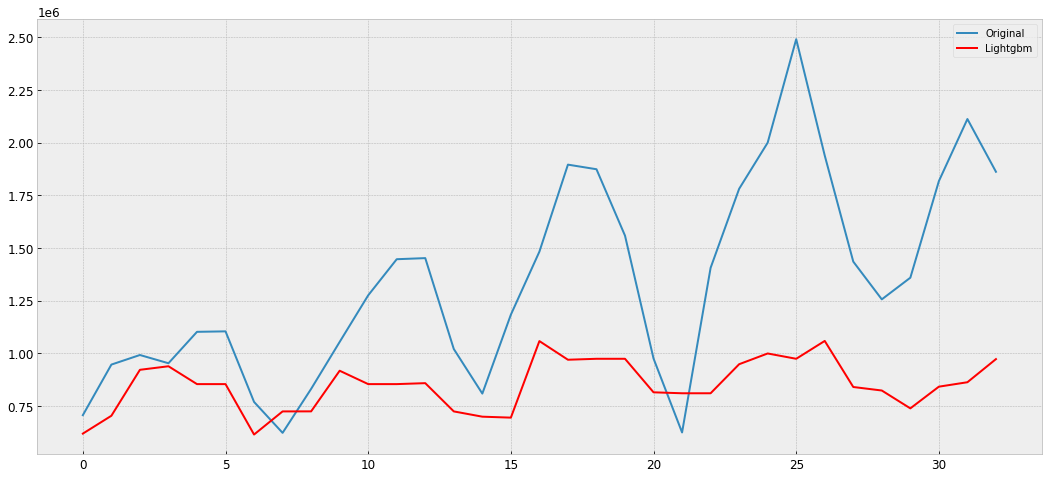

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat,color='red',label='Lightgbm')
plt.legend()

### Support vector machines

Explain multiple kernels balbla

In [ ]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
MAE['SVM RBF'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat)
RMSE['SVM RBF'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat)
R2_Metric['SVM RBF'] = r2_score(df_test.daily_new_fully_vaccinated, yhat)
predictionsDict['SVM RBF'] = yhat

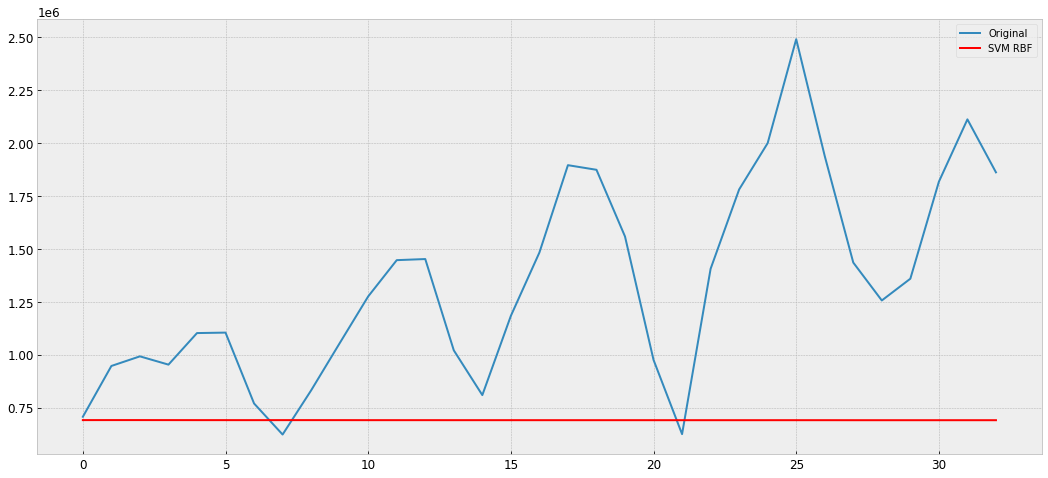

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat,color='red',label='SVM RBF')
plt.legend()

### Nearest neighbors

In [ ]:
reg = KNeighborsRegressor(n_neighbors=2)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
MAE['Kneighbors'] = mean_absolute_error(df_test.daily_new_fully_vaccinated, yhat)
RMSE['Kneighbors'] = mean_squared_error(df_test.daily_new_fully_vaccinated, yhat)
R2_Metric['Kneighbors'] = r2_score(df_test.daily_new_fully_vaccinated, yhat)
predictionsDict['Kneighbors'] = yhat

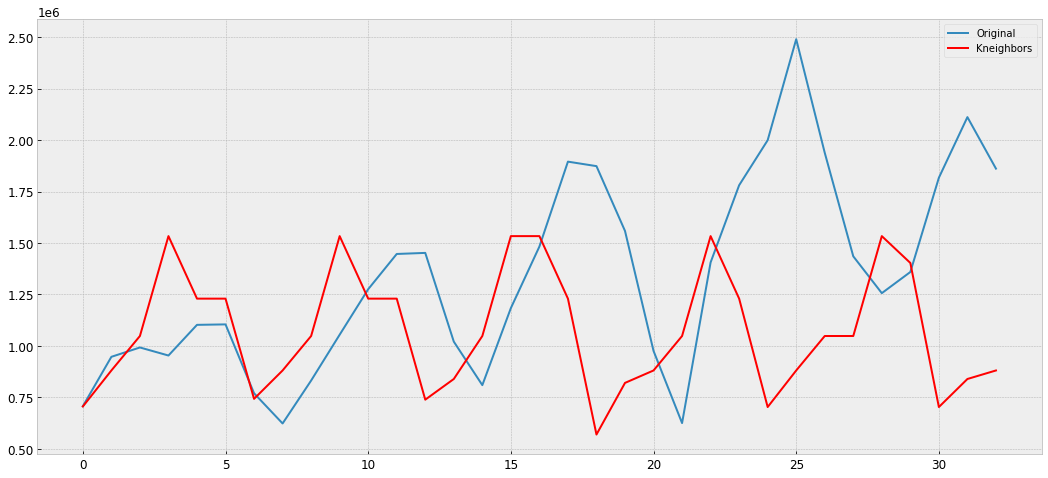

In [ ]:
plt.plot(df_test.daily_new_fully_vaccinated.values , label='Original')
plt.plot(yhat,color='red',label='Kneighbors')
plt.legend()

### Deep learning

#### Tensorlfow LSTM

LSTM are a special type of neural network architecture, you can read more on this [here](https://www.tensorflow.org/guide/keras/rnn)

We will be trying a LSTM model for our benchmark but we will need to reshape our data to provide the network a window of previous samples (past days data) for each y target value. Find the code here

In [ ]:
#For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 64
BUFFER_SIZE = 100
WINDOW_LENGTH = 24
def window_data(X,Y,window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x=[]
    y=[]
    for i in range(window-1,len(X)):
        x.append(X[i-window+1:i+1]) 
        y.append(Y[i])
    return np.array(x), np.array(y)
        
#Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w,y_w = window_data(X_w,y_w,window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

#Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [ ]:
dropout=0.0
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=X_train_w.shape[-2:],dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='rmsprop', loss='mae')

# logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S") #Support for tensorboard tracking!
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
EVALUATION_INTERVAL = 200
EPOCHS = 5

model_history = simple_lstm_model.fit(train_data, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_data, validation_steps=50)#,callbacks=[tensorboard_callback]) #Uncomment this line for tensorboard support

Epoch 1/5
200/200 [==============================] - 4s 11ms/step - loss: 842722.6720 - val_loss: 1314641.1250
Epoch 2/5
200/200 [==============================] - 2s 9ms/step - loss: 763526.4642 - val_loss: 1237337.2500
Epoch 3/5
200/200 [==============================] - 2s 9ms/step - loss: 504067.0625 - val_loss: 1063167.8750
Epoch 4/5
200/200 [==============================] - 2s 9ms/step - loss: 201651.2363 - val_loss: 1028102.6250
Epoch 5/5
200/200 [==============================] - 2s 9ms/step - loss: 189982.0876 - val_loss: 1028005.7500


In [ ]:
yhat = simple_lstm_model.predict(X_test_w).reshape(1,-1)[0]
MAE['Tensorflow simple LSTM'] = mean_absolute_error(y_test.values, yhat)
RMSE['Tensorflow simple LSTM'] = mean_squared_error(y_test.values, yhat)
R2_Metric['Tensorflow simple LSTM'] = r2_score(y_test.values, yhat)
predictionsDict['Tensorflow simple LSTM'] = yhat

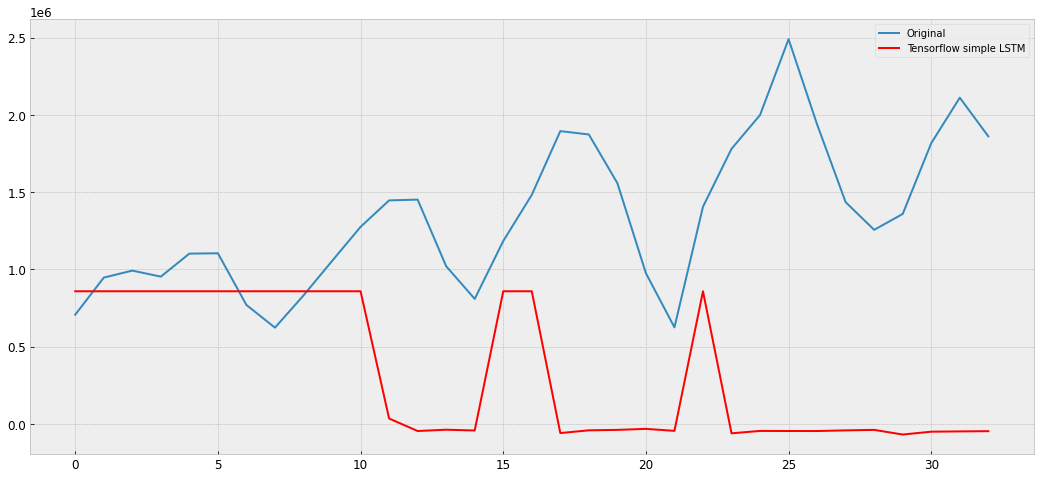

In [ ]:
plt.plot(y_test.values , label='Original')
plt.plot(yhat,color='red',label='Tensorflow simple LSTM')
plt.legend()

# Appendix

## Hyperparameter optimization

### Grid search - SVM

In [ ]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
MAE['SVM RBF GRID SEARCH'] = mean_absolute_error(df_test.daily_new_fully_vaccinated.values, yhat)
RMSE['SVM RBF GRID SEARCH'] = mean_squared_error(df_test.daily_new_fully_vaccinated.values, yhat)
R2_Metric['SVM RBF GRID SEARCH'] = r2_score(df_test.daily_new_fully_vaccinated.values, yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [ ]:
increase = 1 - (RMSE['SVM RBF GRID SEARCH']/RMSE['SVM RBF'])
print(f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is -0.02580040251207727% better than the SVM with default parameters


### Bayesian processes - Xgboost

In [ ]:
def rms(y_actual,y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))

my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3,15),
    'min_samples_leaf': (1,4),
    'min_samples_split': (2,10),
}
 
def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = RandomForestRegressor(n_estimators=n_estimators, 
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)
    
    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))
 
optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)

In [ ]:
optimizer.maximize(
    init_points=3,
    n_iter=20,
    acq='ei'
)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
|  1        |  1.109    |  8.004    |  3.161    |  2.001    |  3.093e+0 |
|  2        |  1.269    |  4.761    |  1.277    |  3.49     |  3.521e+0 |
|  3        |  1.127    |  7.761    |  2.616    |  5.354    |  6.884e+0 |
|  4        |  1.101    |  4.298    |  3.175    |  5.441    |  3.52e+03 |
|  5        |  1.146    |  8.311    |  2.24     |  6.382    |  7.468e+0 |
|  6        |  1.358    |  10.48    |  1.67     |  9.673    |  8.066e+0 |
|  7        |  1.214    |  3.254    |  3.424    |  9.719    |  7.051e+0 |
|  8        |  1.262    |  7.373    |  1.067    |  3.219    |  9.718e+0 |
|  9        |  1.312    |  14.94    |  1.976    |  8.535    |  541.9    |
|  10       |  1.349    |  14.77    |  1.811    |  8.47     |  4.521e+0 |
|  11       |  1.12     |  6.899    |  2.907    |  5.204    |  7.54e+03 |
|  12       |  1.11     |  6.671    | 

In [ ]:
params = optimizer.max['params']

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['min_samples_leaf']= int(params['min_samples_leaf'])
params['min_samples_split']= int(params['min_samples_split'])

#Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
tunned_rf.fit(X_train, y_train) # Change verbose to True if you want to see it train

yhat = tunned_rf.predict(X_test)
MAE['Randomforest tunned'] = mean_absolute_error(y_test, yhat)
RMSE['Randomforest tunned'] = mean_squared_error(y_test, yhat)
R2_Metric['Randomforest tunned'] = r2_score(y_test, yhat)

In [ ]:
increase = 1 - (RMSE['Randomforest tunned']/RMSE['Randomforest'])
print(f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 8.028078207069845% better than the Randomforest with default parameters


## Ensembling

In [ ]:
models = ['Tensorflow simple LSTM',
 'Lightgbm',
 'XGBoost']
resis = pd.DataFrame(data={k: df_test.daily_new_fully_vaccinated.values - v for k, v in predictionsDict.items()})[models]
corr = resis.corr()
print("Residuals correlation")
corr.style.background_gradient(cmap='coolwarm')

Residuals correlation


,Tensorflow simple LSTM,Lightgbm,XGBoost
Tensorflow simple LSTM,1.000000,0.882981,0.880622
Lightgbm,0.882981,1.000000,0.951781
XGBoost,0.880622,0.951781,1.000000


We can see how both tree models are a bit similar. In this case it would really make sense to ensemble the methods and see how they behave. The most reasonable combinations to try would be

* XGboost + Tensorflow
* XGBoost + Lightgbm
* Lightgbm + Tensorflow
* XGBoost + Lightgbm + Tensorflow

We will just sum the predictions of each model with similar weights (0.5 if two models, 0.333 if three)

In [ ]:
predictionsDict['EnsembleXG+LIGHT'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm'])/2
MAE['EnsembleXG+LIGHT'] = mean_absolute_error(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleXG+LIGHT'])
RMSE['EnsembleXG+LIGHT'] = mean_squared_error(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleXG+LIGHT'])
R2_Metric['EnsembleXG+LIGHT'] = r2_score(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleXG+LIGHT'])


predictionsDict['EnsembleXG+LIGHT+TF'] = (predictionsDict['XGBoost'] + predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/3
MAE['EnsembleXG+LIGHT+TF'] = mean_absolute_error(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleXG+LIGHT+TF'])
RMSE['EnsembleXG+LIGHT+TF'] = mean_squared_error(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleXG+LIGHT+TF'])
R2_Metric['EnsembleXG+LIGHT+TF'] = r2_score(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleXG+LIGHT+TF'])


predictionsDict['EnsembleLIGHT+TF'] = (predictionsDict['Lightgbm']+ predictionsDict['Tensorflow simple LSTM'])/2
MAE['EnsembleLIGHT+TF'] = mean_absolute_error(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleLIGHT+TF'])
RMSE['EnsembleLIGHT+TF'] = mean_squared_error(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleLIGHT+TF'])
R2_Metric['EnsembleLIGHT+TF'] = r2_score(df_test.daily_new_fully_vaccinated.values, predictionsDict['EnsembleLIGHT+TF'])


predictionsDict['EnsembleXG+TF'] = (predictionsDict['XGBoost']+ predictionsDict['Tensorflow simple LSTM'])/2
MAE['EnsembleXG+TF'] = mean_absolute_error(df_test.daily_new_fully_vaccinated.values,predictionsDict['EnsembleXG+TF'])
RMSE['EnsembleXG+TF'] = mean_squared_error(df_test.daily_new_fully_vaccinated.values,predictionsDict['EnsembleXG+TF'])
R2_Metric['EnsembleXG+TF'] = r2_score(df_test.daily_new_fully_vaccinated.values,predictionsDict['EnsembleXG+TF'])

## Model Comparison

In [ ]:
criteria=pd.DataFrame([MAE,RMSE,R2_Metric], index=['MAE', 'RMSE','R2_Metric'])
criteria=criteria.T
print(criteria)

                                 MAE          RMSE  R2_Metric
SES                     3.092209e+05  1.276935e+11   0.421426
HWES                    3.092209e+05  1.276935e+11   0.421426
AR                      2.527557e+05  9.078599e+10   0.588652
MA                      3.981084e+05  2.306476e+11  -0.045054
ARMA                    3.063918e+05  1.316983e+11   0.403280
ARIMA                   3.016945e+05  1.289725e+11   0.415631
SARIMAX                 2.899430e+05  1.150589e+11   0.478673
BayesianRidge           6.707840e+05  6.627887e+11  -2.003068
Lasso                   2.686174e+05  1.263246e+11   0.427629
Randomforest            4.571457e+05  3.693945e+11  -0.673711
XGBoost                 5.928896e+05  5.667630e+11  -1.567980
Lightgbm                5.052133e+05  3.958705e+11  -0.793673
SVM RBF                 6.546835e+05  6.388445e+11  -1.894578
Kneighbors              4.699899e+05  4.183059e+11  -0.895327
Tensorflow simple LSTM  1.028005e+06  1.650475e+12  -6.478233
SVM RBF 

<AxesSubplot:>

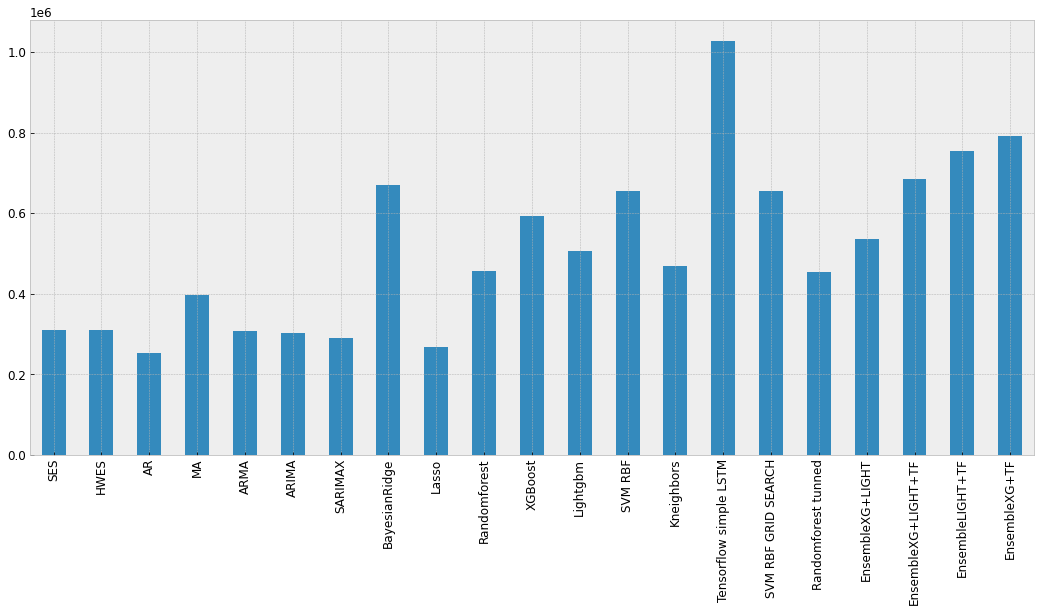

In [ ]:
criteria.MAE.plot.bar(x='Method', y='Value')

<AxesSubplot:>

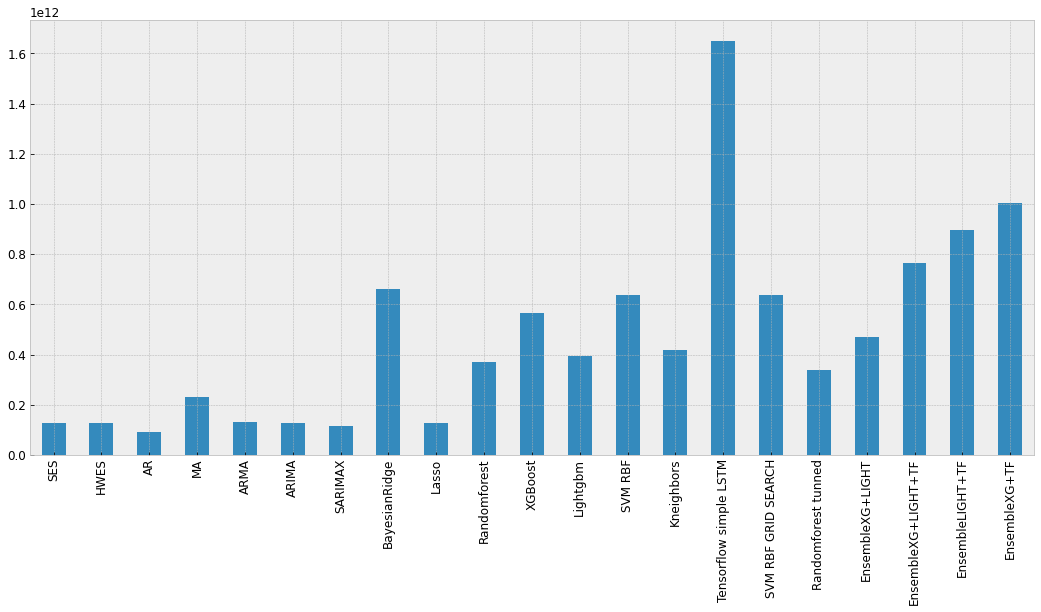

In [ ]:
criteria.RMSE.plot.bar(x='Method', y='Value')

<AxesSubplot:>

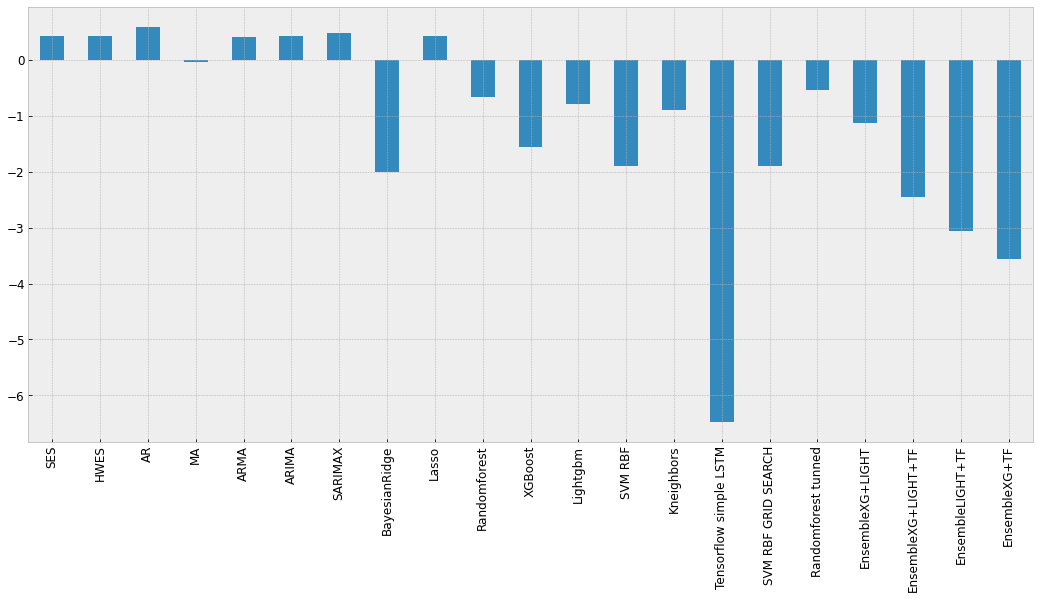

In [ ]:
criteria.R2_Metric.plot.bar(x='Method', y='Value')

Therefore, the best time series forecasting model with current data is SARIMA Model.